In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import os

csvfile = pd.read_csv("asdfsad.csv")

In [3]:
# Creating base data
# used to see the wav files and the emotion it's associated with. Don't modify this dataframe. It'll be used to make the main dataframe
mdf = pd.DataFrame(columns=["emotion", "wav"])
crema = "./Crema/"

sad=[]
angry=[]
disgust=[]
fear=[]
happy=[]
neutral=[]

sample_rate=16000

for wav in os.listdir(crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        mdf.loc[len(mdf.index)] = ['sad', wavfile.read(crema + wav)[1]]
    elif info[2] == 'ANG':
        mdf.loc[len(mdf.index)] = ['angry', wavfile.read(crema + wav)[1]]
    elif info[2] == 'DIS':
        mdf.loc[len(mdf.index)] = ['disgust', wavfile.read(crema + wav)[1]]
    elif info[2] == 'FEA':
        mdf.loc[len(mdf.index)] = ['fear', wavfile.read(crema + wav)[1]]
    elif info[2] == 'HAP':
        mdf.loc[len(mdf.index)] = ['happy', wavfile.read(crema + wav)[1]]
    elif info[2] == 'NEU':
        mdf.loc[len(mdf.index)] = ['neutral', wavfile.read(crema + wav)[1]]

In [4]:
print(mdf)

      emotion                                                wav
0     disgust  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       angry  [-81, -98, -97, -115, -91, -70, -41, -41, -66,...
2         sad  [157, 137, 148, 143, 132, 106, 119, 105, 67, 8...
3       angry  [70, 41, 51, 51, 48, 47, 52, 44, 21, 12, 4, -1...
4         sad  [201, 251, 258, 243, 231, 237, 259, 226, 245, ...
...       ...                                                ...
7437    angry  [249, 291, 277, 342, 330, 330, 337, 341, 335, ...
7438    angry  [-31, -42, -29, -25, -7, -18, 9, -26, -34, -51...
7439    angry  [-182, -173, -183, -187, -206, -190, -198, -22...
7440      sad  [-23, 2, 9, -13, -13, 22, 0, -3, 13, 19, 10, -...
7441  disgust  [-314, -282, -252, -186, -127, -60, 12, 89, 15...

[7442 rows x 2 columns]


In [5]:
# Create dataframe used for manipulation
df = mdf.copy()
df = df.drop(columns=["wav"])
df["mean"]=0
df["zero crossing rate"]=0
df["rmse"]=0

# Add more features here

for i in range(0, len(df)):
    # save the mean. Probably wont really use.
    df["mean"].loc[i] = mdf["wav"].loc[i].mean()
    # save the zero crossing rate.
    df["zero crossing rate"].loc[i] = librosa.feature.zero_crossing_rate(mdf["wav"].loc[i].astype(np.float))[0].mean()
    # save rms of the energy of the signal
    df["rmse"].loc[i] = librosa.feature.rms(mdf["wav"].loc[i].astype(np.float))[0].mean()
    

/home/devlin/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_10426/3783060016.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df["zero crossing rate"].loc[i] = librosa.feature.zero_crossing_rate(mdf["wav"].loc[i].astype(np.float))[0].mean()
/tmp/ipykernel_10426/3783060016.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin

/tmp/ipykernel_10426/4149576908.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  half_len_f1 = np.ceil((len_f1 + 1) / 2).astype(np.int)
/tmp/ipykernel_10426/4149576908.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

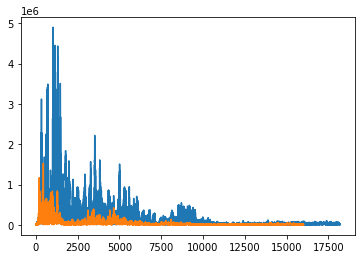

In [30]:
# visualize fft
rate1, sig1 = wavfile.read(crema + "1001_DFA_ANG_XX.wav")
rate2, sig2 = wavfile.read(crema + "1001_DFA_SAD_XX.wav")
sig_f1 = abs(np.fft.fft(sig1))
sig_f2 = abs(np.fft.fft(sig2))
len_f1 = len(sig_f1)
len_f2 = len(sig_f2)
half_len_f1 = np.ceil((len_f1 + 1) / 2).astype(np.int)
half_len_f2 = np.ceil((len_f2 + 1) / 2).astype(np.int)
sig_f1 = sig_f1[:half_len_f1]
sig_f2 = sig_f2[:half_len_f2]

plt.plot(sig_f1)
plt.plot(sig_f2)

In [29]:
# frequency domain data

df["average frequency"]=0

for i in range(0, len(df)):
    df["average frequency"].loc[i] = abs(np.fft.fft(mdf["wav"].loc[i])).mean()

/home/devlin/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


   emotion      mean  zero crossing rate         rmse  average frequency
0  disgust -1.020297            0.095886  2479.977572      305514.086458
1    angry  0.409421            0.149925   660.629696      126336.971318
2      sad -0.732631            0.195542   231.298417       37476.855139
3    angry -0.944036            0.069248  1382.230487      150150.264841
4      sad -2.165303            0.120218   331.006868       30594.404031
                        mean  zero crossing rate      rmse  average frequency
mean                1.000000            0.021222 -0.185199          -0.171832
zero crossing rate  0.021222            1.000000  0.320956           0.411489
rmse               -0.185199            0.320956  1.000000           0.958726
average frequency  -0.171832            0.411489  0.958726           1.000000


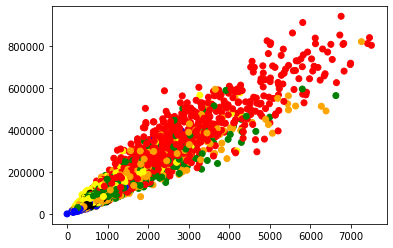

In [27]:
print(df.head())
print(df.corr())
colors = {"sad":"blue", "angry":"red", "disgust":"yellow", "fear":"orange", "happy":"green", "neutral":"black"}
plt.scatter(np.abs(df["rmse"]), df["average frequency"], c=df["emotion"].map(colors))